In [1]:
import math
import random
from random import randint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import IPython as ip

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import yacht_main as yacht
from yacht_test import create_train_set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.dice1 = nn.Linear(input_size, 100)
        self.dice2 = nn.Linear(100, 100)
        self.dice3 = nn.Linear(100, 100)
        self.dice4 = nn.Linear(100, 100)
        self.dice5 = nn.Linear(100, 100)
        self.dice6 = nn.Linear(100, 100)
        self.dice7 = nn.Linear(100, output_size)
        self.score1 = nn.Linear(12, 12)
        
        
    def forward(self, x):
        x = torch.sigmoid(self.dice1(x[:,12:17]))
        x = torch.sigmoid(self.dice2(x))
        x = torch.sigmoid(self.dice3(x))
        x = torch.sigmoid(self.dice4(x))
        x = torch.sigmoid(self.dice5(x))
        x = torch.sigmoid(self.dice6(x))
        x = self.dice7(x)
        x = x
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.constant_(m,0.1)

In [4]:
EPS_START = 0.9
EPS_END = 0.5
EPS_DECAY = 10000000
steps_done = 0
INPUT_SIZE = 1
OUTPUT_SIZE = 1
TARGET_UPDATE = 20
TRAINSET_UPDATE = 1000
policy_net = None
target_net = None

def select_action(state, avail):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    """
    if sample > eps_threshold:
        with torch.no_grad():
            policy_net(state)
            return (policy_net(state) * avail).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(OUTPUT_SIZE)]], device=device, dtype=torch.long)
    """
    if sample <= eps_threshold:
        random_action = 0
        randomizer = randint(1, avail.sum())
        avail_list = torch.reshape(avail,[-1]).tolist()
        for i in range(len(avail_list)):
            if avail_list[i] == 1:
                if randomizer == 1:
                    random_action = i
                    break
                randomizer -= 1
        return torch.tensor([[random_action]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            a = policy_net(state)
            #a -= a.min()
            return a.max(1)[1].view(1, 1)


episode_scores = []
episode_success = []

def plot_scores():
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    success_t = torch.tensor(episode_success, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores_t.numpy())
    if len(scores_t) >= 50:
        means = scores_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())
    if len(success_t) >= 50:
        sucm = success_t.unfold(0, 50, 1).mean(1).view(-1)
        sucm = torch.cat((torch.zeros(49), sucm))
        plt.plot(sucm.numpy())

    ip.display.clear_output(wait=True)
    plt.pause(0.001)

In [5]:
def init_net(isize, osize, msize):
    global policy_net, target_net, optimizer, memory, EPS_START, EPS_END, EPS_DECAY, steps_done, episode_scores
    global TARGET_UPDATE, INPUT_SIZE, OUTPUT_SIZE
    INPUT_SIZE = isize
    OUTPUT_SIZE = osize

    MEMORY_SIZE = msize

    TARGET_UPDATE = 5

    memory = ReplayMemory(MEMORY_SIZE)

    policy_net = DQN(INPUT_SIZE,OUTPUT_SIZE).to(device)
    target_net = DQN(INPUT_SIZE,OUTPUT_SIZE).to(device)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

    #init_weights(policy_net)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 500
    steps_done = 0

    episode_scores = []

In [6]:
BATCH_SIZE = 512
GAMMA = 0
reward_rate = 0.1
regul = 0


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1)) + torch.norm(policy_net(state_batch)) * regul
    """print('state ex: ' + str(state_batch[0]))
    print('action:' + str(action_batch.view(-1)))
    print('reward:' + str(reward_batch.view(-1)))
    print('value:' + str(state_action_values.view(-1)))
    print('expected:' + str(expected_state_action_values.unsqueeze(1).view(-1)))
    """
    
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    """state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    print('after:' + str(state_action_values.view(-1)))
    print('\n')"""
    

In [7]:
def add_trainset():
    print("Creating train set...")
    train_set_size = 3000 // 5
    train_set = create_train_set(train_set_size)
    for state, action, new_state, step_reward in train_set:
        state_tensor = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
        action_tensor = torch.tensor([[action]], device=device, dtype=torch.long)
        new_state_tensor = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
        step_reward_tensor = torch.tensor([step_reward], device=device, requires_grad = False)
        memory.push(state_tensor.reshape(1,INPUT_SIZE), action_tensor, new_state_tensor.reshape(1,INPUT_SIZE), step_reward_tensor)
    print("Created", train_set_size * 5, "train set")

In [8]:
def net1_main():
    global episode_scores, episode_success
    init_net(20, 12, 3000)

    num_episodes = 1000000
    made_prob = 0.9
    episode_scores = []
    episode_success = []

    for i_episode in range(num_episodes):
        yacht.reset_game()
        state, score, _, avail = yacht.get_yacht_output()
        state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
        for t in count():
            avail = avail[31:]
            avail = torch.tensor(avail, dtype=torch.float, device=device, requires_grad = False)
            action = select_action(state.reshape(1,INPUT_SIZE), avail) + 31
            reward = yacht.update(action)

            new_state, _, done, avail = yacht.get_yacht_output()
            step_reward = torch.tensor([reward], device=device, requires_grad = False)
            
            #print(str(action) + ' ' + str(reward) + ' ' + str(yacht.dice_status))
            
            if random.random() < made_prob:
                yacht.handled_roll()

            if not done:
                new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
                memory.push(state.reshape(1,INPUT_SIZE), action - 31, new_state.reshape(1,INPUT_SIZE), \
                        step_reward)
            else:
                new_state = None
                memory.push(state.reshape(1,INPUT_SIZE), action - 31, None, \
                        step_reward)

            state = new_state

            optimize_model()
            if done:
                state, score, _, _ = yacht.get_yacht_output()
                episode_success.append(state[:12].count(-1) * 10)
                episode_scores.append(score)
                
                #print("{0}) {1}\tscore : {2}, turns = {3}".format(i_episode, state[:12], score, t+1))

                if i_episode % 200 == 0:
                    plot_scores()

                break
        if i_episode %
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if i_episode % 10000 == 0:
            torch.save(policy_net.state_dict(), './data/net1/net_' + str(i_episode//10000))

    print('Complete')

In [9]:
def net2_main(net1_name):
    global episode_scores
    init_net(20, 32, 3000)
    
    reward_net = DQN(20, 12).to(device)
    reward_net.load_state_dict(torch.load('./data/net1/' + net1_name))
    reward_net.eval()
    reward_net.requires_grad = False
    
    num_episodes = 500000
    made_prob = 0.66
    episode_scores = []

    for i_episode in range(num_episodes):
        yacht.reset_game()
        state, score, _, avail = yacht.get_yacht_output()
        state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
        for t in count():
            avail = torch.tensor(avail, dtype=torch.float, device=device, requires_grad = False)
            action = select_action(state.reshape(1,INPUT_SIZE), avail)
            
            if action >= 31:
                a = policy_net(state)
                a -= a.min()
                action = (a * avail[31:]).max(1)[1].view(1, 1)
            yacht.update(action)

            new_state, _, done, avail = yacht.get_yacht_output()
            step_reward = reward_net(state).max(1)[0]


            if not done:
                new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
                memory.push(state.reshape(1,INPUT_SIZE), action, new_state.reshape(1,INPUT_SIZE), \
                        step_reward)
            else:
                new_state = None
                memory.push(state.reshape(1,INPUT_SIZE), action, None, \
                        step_reward)

            state = new_state

            optimize_model()
            if done:
                state, score, _, _ = yacht.get_yacht_output()
                episode_scores.append(score)
                if i_episode % 200 == 0:
                    plot_scores()

                break

        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if i_episode % 10000 == 0:
            torch.save(policy_net.state_dict(), './data/net2/net_' + str(i_episode//10000))

    print('Complete')

In [9]:
def net3_main():
    global episode_scores
    policy_net = DQN(5,OUTPUT_SIZE).to(device)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

    for i_episode in range(num_episodes):
        yacht.reset_game()
        state, score, _, avail = yacht.get_yacht_output()
        state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
        for t in count():
            avail = torch.tensor(avail, dtype=torch.float, device=device, requires_grad = False)
            action = select_action(state.reshape(1,INPUT_SIZE), avail)
            
            if action >= 31:
                a = policy_net(state)
                a -= a.min()
                action = (a * avail[31:]).max(1)[1].view(1, 1)
            yacht.update(action)

            new_state, _, done, avail = yacht.get_yacht_output()
            step_reward = reward_net(state).max(1)[0]


            if not done:
                new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
                memory.push(state.reshape(1,INPUT_SIZE), action, new_state.reshape(1,INPUT_SIZE), \
                        step_reward)
            else:
                new_state = None
                memory.push(state.reshape(1,INPUT_SIZE), action, None, \
                        step_reward)

            state = new_state

            optimize_model()
            if done:
                state, score, _, _ = yacht.get_yacht_output()
                episode_scores.append(score)
                if i_episode % 200 == 0:
                    plot_scores()

                break

        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if i_episode % 10000 == 0:
            torch.save(policy_net.state_dict(), './data/net2/net_' + str(i_episode//10000))

    print('Complete')

In [10]:
net1 = DQN(20, 12)
net2 = DQN(20, 32)
def duel_action(state):
    action = net2(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1]

    if action == 31:
        action = net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1]
    return action

In [11]:
def test_model(net1r,net2r):
    net1 = DQN(20, 12)
    net1.load_state_dict(torch.load('./data/net1/' + net1r))
    net1.eval()
    net2 = DQN(20, 32)
    net2.load_state_dict(torch.load('./data/net2/' + net2r))
    net2.eval()
    
    yacht.reset_game()
    done = False
    while not done :
        state,reward,done,_ = yacht.get_yacht_output()
        print(state)
        action = duel_action(state)
        yacht.update(action)
        print(action)

In [12]:
def test_net1(net1r):
    net1 = DQN(20, 12)
    net1.load_state_dict(torch.load('./data/net1/' + net1r))
    net1.eval()
    
    yacht.reset_game()
    done = False
    while not done :
        yacht.handled_roll()
        state,reward,done,_ = yacht.get_yacht_output()
        print(state)
        action = net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1] + 31
        yacht.update(action)
        print(action)

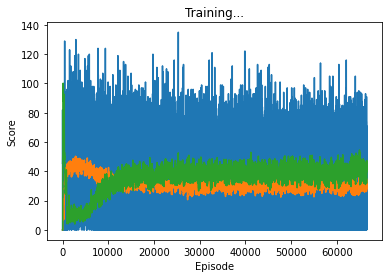

KeyboardInterrupt: 

In [13]:
net1_main()

In [ ]:
net2_main('net_99')

In [ ]:
test_model('net_', 'net_')

In [ ]:
test_net1('net_49')

In [ ]:
net1r = 'net_5'
net1 = DQN(45, 12)
net1.load_state_dict(torch.load('./data/net1/' + net1r))
net1.eval()


In [ ]:
yacht.reset_game()
done = False
while not done :
    yacht.handled_roll()
    state,reward,done,_ = yacht.get_yacht_output()
    print(state)
    print(net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(-1)))
    action = net1(torch.tensor(state, dtype=torch.float, requires_grad = False).reshape(1, 45)).max(1)[1] + 31
    yacht.update(action)
    print(str(action) + ' ' + str(reward))